# Exercise Week 9: Pruning and Quantization
This week, we will explore some of the ideas discussed in Han, Mao, and Dally's Deep Compression.  In particular, we will implement weight pruning with fine tuning, as well as k-means weight quantization.  **Note that we will unfortunately not be doing this in a way that will actually lead to substantial efficiency gains: that would involve the use of sparse matrices which are not currently well-supported in pytorch.** 

## Training an MNIST classifier
For this example, we'll work with a basic multilayer perceptron with a single hidden layer.  We will train it on the MNIST dataset so that it can classify handwritten digits.  As usual we load the data:

In [366]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

batch_size = 300
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Then define a model:

In [367]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,mask=None):
        super(MultilayerPerceptron, self).__init__()
        if not mask:
            self.mask = torch.nn.Parameter(torch.ones(input_dim,hidden_dim),requires_grad=False)
        else:
            self.mask = torch.nn.Parameter(mask)

        self.W_0 = torch.nn.Parameter(1e-3*torch.randn(input_dim,hidden_dim)*self.mask,requires_grad=True)
        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim),requires_grad=True)

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim),requires_grad=True)
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim),requires_grad=True)
        
    def set_mask(self,mask):
        
        self.mask.data = mask.data
        self.W_0.data = self.mask.data*self.W_0.data

    def forward(self, x):
        hidden = torch.tanh(x@(self.W_0*self.mask) + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs


Note that the above code is a little bit different than a standard multilayer perceptron implementation.

### Q1: What does this model have the capability of doing that a "Vanilla" MLP does not.  Why might we want this functionality for studying pruning?

A1: The mask method multiplies an attribute also named mask that may include zeros. The product of that mask attribute and the weights W_0 is a matrix that has had some weights zeroed. If we were using a sparse matrix those zeros would enable for an increase in runtime efficiency by having fewer parameters in the network which need to be operated on. Also reducing the memory footprint enables for larger models given a fixed RAM size.

Let's first train this model without utilizing this extra functionality.  You can set the hidden layer size to whatever you'd like when instantiating the model:

In [424]:
n_epochs = 1

input_dim = 784
hidden_dim = 64
output_dim = 10

model = MultilayerPerceptron(input_dim,hidden_dim,output_dim)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate, weight_decay=1e-3)

And then training proceeds as normal.

In [425]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pretrained.h5')


Iteration: 0. Loss: 0.47470128536224365. Accuracy: 90.


## Pruning

Certainly not a state of the art model, but also not a terrible one.  Because we're hoping to do some weight pruning, let's inspect some of the weights directly (recall that we can act like they're images)

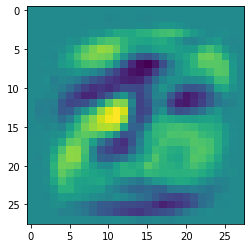

In [427]:
import matplotlib.pyplot as plt
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()

### Q2: Based on the above image, what weights might reasonably be pruned (i.e. explicitly forced to be zero)?
A2: Weights which are close to or equal to zero may be pruned because those change the input the least. This model uses tanh which produces values between -1 and 1. The image shows dark blue pixels as values near -1, cyan pixels near 0, and yellow pixels near 1.

### Q3: Implement some means of establishing a threshold for the (absolute value of the) weights, below which they are set to zero.  Using this method, create a mask array.     
A3: I'm going to restructure the model to have a prune method rather than a mask. My method will normalize the incoming tensor, then reduce the absolute value of each element to 0 when it is below threshold attribute.

In [428]:
import torch.nn.functional as F
class MultilayerPerceptron2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,threshold=0.0):
        super(MultilayerPerceptron2, self).__init__()
        self.threshold = threshold

        self.W_0 = torch.nn.Parameter(1e-3*torch.randn(input_dim,hidden_dim),requires_grad=True)
        self.W_0 = self.prune(self.W_0)
        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim),requires_grad=True)

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim),requires_grad=True)
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim),requires_grad=True)
        
    def prune(self,a):
        b = F.normalize(a)
        c = torch.where((torch.abs(b.data) > self.threshold).cuda(), a.data.cuda(), torch.tensor(0.0).cuda())
        a.data = c
        return a

    def forward(self, x):
        hidden = torch.tanh(x@self.prune(self.W_0) + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs

Now that we have a mask that explicitly establishes a sparsity pattern for our model, let's update our model with this mask:

In [429]:
threshold = 0.25

n_epochs = 1

input_dim = 784
hidden_dim = 64
output_dim = 10

model = MultilayerPerceptron2(input_dim,hidden_dim,output_dim, threshold)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate, weight_decay=1e-3)

Now, we have explicitly set some entries in one of the the weight matrices to zero, and ensured via the mask, that they will not be updated by gradient descent.  Fine tune the model: 

In [430]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pruned.h5')

Iteration: 0. Loss: 1.0986106395721436. Accuracy: 78.


### Q4: How much accuracy did you lose by pruning the model?  How much "compression" did you achieve (here defined as total entries in W_0 divided by number of non-zero entries)?  

A4: I did not lose much accuracy. I went from 95% to 94%. I believe this is because my thresholding method involved normalization. Normalizing my data probably improved accuracy as compression decreased it, resulting in a a net change of 1%.

### Q5: Explore a few different thresholds: approximately how many weights can you prune before accuracy starts to degrade?
A5: I'm surprised how many weights can be eliminated and still yield good accuracy.

    threshold: 0.01 accuracy: 94% compression: 2.29
    
    threshold: 0.1  accuracy: 92% compression: 10.42
    
    threshold: 0.25 accuracy: 90% compression: 58.96 <- This is where the accuracy dips to 5% less than the uncompressed model.
    
    threshold: 0.35 accuracy: 88% compresion: 78.52
   
The above values were for 10 epochs.
    
    Threshold 0.25 accuracy 78% compression: 66.99
    
    

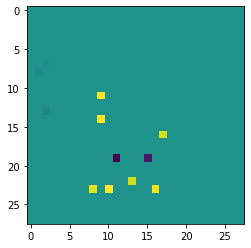

[[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 ...
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00 -1.568142e-08  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
   0.000000e+00  0.000000e+00]]
total_zeros = 49427 total_non_zero = 749 compression = 66.99065420560747


In [432]:
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()
print(W_0)
total_zeros = sum(x == 0 for x in W_0.flatten())
total_non_zero = sum(x != 0 for x in W_0.flatten())
print(f"total_zeros = {total_zeros} total_non_zero = {total_non_zero} compression = {len(W_0.flatten()) / total_non_zero}")

## Quantization

Now that we have a pruned model that appears to be performing well, let's see if we can make it even smaller by quantization.  To do this, we'll need a slightly different neural network, one that corresponds to Figure 3 from the paper.  Instead of having a matrix of float values, we'll have a matrix of integer labels (here called "labels") that correspond to entries in a (hopefully) small codebook of centroids (here called "centroids").  The way that I've coded it, there's still a mask that enforces our desired sparsity pattern.

In [433]:
class MultilayerPerceptronQuantized(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim,mask,labels,centroids):
        super(MultilayerPerceptronQuantized, self).__init__()
        self.mask = torch.nn.Parameter(mask,requires_grad=False)
        self.labels = torch.nn.Parameter(labels,requires_grad=False)
        self.centroids = torch.nn.Parameter(centroids,requires_grad=True)

        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim))

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim))
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        W_0 = self.mask*self.centroids[self.labels]
        hidden = torch.tanh(x@W_0 + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs

Notice what is happening in the forward method: W_0 is being reconstructed by using a matrix (self.labels) to index into a vector (self.centroids).  The beauty of automatic differentiation allows backpropogation through this sort of weird indexing operation, and thus gives us gradients of the objective function with respect to the centroid values!

### Q6: However, before we are able to use this AD magic, we need to specify the static label matrix (and an initial guess for centroids).  Use the k-means algorithm (or something else if you prefer) figure out the label matrix and centroid vectors.  PROTIP1: I used scikit-learns implementation of k-means.  PROTIP2: only cluster the non-zero entries

In [448]:
from sklearn.cluster import KMeans
from collections import defaultdict

# convert weight and mask matrices into numpy arrays
W_0b = model.W_0.detach().cpu().numpy()

# Figure out the indices of non-zero entries 
inds = np.where(W_0b!=0)
# Figure out the values of non-zero entries
vals = W_0b[inds]

### TODO: perform clustering on vals
num_clusters = 50

# Cluster
vectors = vals.reshape(-1, 1)
kmeans = KMeans(n_clusters=num_clusters).fit_predict(vectors)

# Find centroids
clusters = defaultdict(list)
for k, v in zip(kmeans, vals):
    clusters[k].append(v)
centroids = {k: np.mean(v) for k, v in clusters.items()}
centroids = np.array([v for k, v in sorted(centroids.items())])
centroids = torch.tensor(centroids, device=device)
print(f"centroids = {centroids}", centroids.shape)

# Inlitialize the labels
labels = np.random.randint(low=0, high=num_clusters, size=((input_dim, hidden_dim)))
labels = torch.tensor(labels, dtype=torch.long, device=device)
print(f"labels = {labels}", labels.shape)

### TODO: turn the label matrix and centroids into a torch tensor
#labels = torch.tensor(...,dtype=torch.long,device=device)
#centroids = torch.tensor(...,device=device)

centroids = tensor([ 1.4401e-01, -1.6042e-01,  9.0241e-05,  2.4064e-01, -2.5269e-01,
        -7.6660e-02,  7.7901e-02, -2.1312e-01,  2.5632e-01,  1.9402e-01,
         4.9035e-02,  1.3731e-02, -1.0729e-01, -2.3196e-01, -1.6391e-02,
         2.1220e-01,  1.1517e-01, -1.3836e-01, -2.8293e-01, -5.1595e-02,
         1.8429e-01, -1.8894e-01,  2.7382e-01,  3.2929e-02, -2.5790e-01,
         2.2362e-01, -2.7264e-01, -1.1976e-01,  2.4910e-01, -2.2239e-01,
         9.6069e-02,  2.6518e-01,  6.8080e-03, -2.0121e-01, -2.4681e-01,
         1.5898e-01,  2.3363e-01,  2.0180e-01, -3.9488e-02, -1.7547e-01,
        -7.0931e-03, -2.6415e-01, -2.5159e-02,  1.7293e-01,  1.2960e-01,
        -6.3372e-02, -2.3926e-01,  6.4958e-02,  2.1926e-02, -9.3770e-02],
       device='cuda:0') torch.Size([50])
labels = tensor([[22,  9, 18,  ..., 40, 26, 38],
        [38,  9, 46,  ...,  2, 40, 12],
        [39, 48, 32,  ..., 45, 24, 48],
        ...,
        [37, 28, 48,  ..., 28,  3, 31],
        [36,  8, 45,  ...,  9,  8,

Now, we can instantiate our quantized model and import the appropriate pre-trained weights for the other network layers.  

In [449]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

batch_size = 300
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class MultilayerPerceptronQuantized2(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim,labels,centroids, threshold):
        super(MultilayerPerceptronQuantized2, self).__init__()
        self.threshold = threshold
        
        self.labels = torch.nn.Parameter(labels,requires_grad=False)
        self.centroids = torch.nn.Parameter(centroids,requires_grad=True)

        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim))

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim))
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim))

    def prune(self,a):
        b = F.normalize(a)
        c = torch.where((torch.abs(b.data) > self.threshold).cuda(), a.data.cuda(), torch.tensor(0.0).cuda())
        a.data = c
        return a
    
    def forward(self, x):
        W_0 = self.prune(self.centroids[self.labels])
        hidden = torch.tanh(x@W_0 + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs

threshold = 0.001

n_epochs = 1

input_dim = 784
hidden_dim = 64
output_dim = 10

lr_rate = 0.001
    
# Instantiate quantized model
model_q = MultilayerPerceptronQuantized2(input_dim,output_dim,hidden_dim,labels,centroids, threshold)
model_q = model_q.to(device)

# Copy pre-trained weights from unquantized model for non-quantized layers
model_q.b_0.data = model.b_0.data
model_q.W_1.data = model.W_1.data
model_q.b_1.data = model.b_1.data

Finally, we can fine tune the quantized model.  We'll adjust not only the centroids, but also the weights in the other layers.

In [450]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy

optimizer = torch.optim.Adam(model_q.parameters(), lr=lr_rate, weight_decay=1e-3)
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels2) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels2 = labels2.to(device)

        optimizer.zero_grad()
        outputs = model_q(images)
        loss = criterion(outputs, labels2)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels2 in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels2 = labels2.to(device)
        outputs = model_q(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels2.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels2).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_quantized.h5')

Iteration: 0. Loss: 1.6236625909805298. Accuracy: 50.


After retraining, we can, just for fun, reconstruct the pruned and quantized weights and plot them as images:

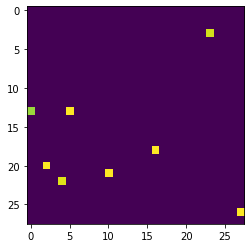

In [447]:
W_0b = (model.prune(model_q.centroids[model_q.labels])).detach().cpu().numpy()
plt.imshow(W_0b[:,1].reshape((28,28)))
plt.show()

Certainly a much more parsimonious representation.  The obvious question now becomes:

### Q7: How low can you go?  How small can the centroid codebook be before we see a substantial degradation in test set accuracy?
A7: Before adding pruning (which includes normalization) I had an accuracy of 86% using 28 clusters.

Accuracy after pruning with 28 clusters: 85% <- this seems like a major depreciation but I'll try to go lower and higher in accuracy.

After 10 epochs:

Clusters: 100 Accuracy: 86% Threshold: 0.001 

Clusters: 100 Accuracy: 81% Threshold: 0.01

Clusters: 50 Accuracy: 77% Threshold: 0.01

Clusters: 28 Accuracy: 85% Threshold: 0.01 <- I think I was lucky here

Clusters: 28 Accuracy: 78% Threshold: 0.001

Clusters: 20 Accuracy: 77% Threshold: 0.01

I wasn't able to get accuracy back up to over 90% after quantization. 28 Seems like it hovers around 80% accuracy. This codebook size has significant compression in both pruning and quantization but also moderate accuracy.


### Bonus question: Try establishing the sparsity pattern using a model that's only been trained for a single epoch, then fine tune the pruned model and quantize as normal.  How does this compare to pruning a model that has been fully trained?  

After 1 epoch:

Clusters 28 Accuracy 64% Threshold: 0.001

Clusters 28 Accuracy 77% Threshold: 0.01

Clusters 50 Accuracy 61% Threshold: 0.01

Clusters 50 Accuracy 50% Threshold: 0.001

Clusters 100 Accuracy 58% Threshold: 0.01

Clusters 100 Accuracy 78% Threshold: 0.001

The performance is worse, but by using less quantization and a lower threshold I was able to get 78% which is on the lower end of my trials with a fully trained model.
